In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()
# 3) If you’re using PyTorch + CUDA, free any lingering GPU memory
import torch
torch.cuda.empty_cache()

import importlib
from libs import models, plots, params
importlib.reload(models)
importlib.reload(plots)
importlib.reload(params)

import pandas as pd
import numpy  as np
import math

import datetime as dt
from datetime import datetime

import copy
from typing import Sequence, List, Tuple, Optional, Union

from tqdm.auto import tqdm

import torch.nn as nn
import torch.nn.functional as Funct
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
from torch_lr_finder import LRFinder

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
###############################################################################
# 0 ·  DATA & PATHS                                                           #
###############################################################################
ticker         = params.ticker
look_back      = params.look_back 
features_cols  = params.features_cols
label_col      = params.label_col
save_path      = params.save_path

date = datetime.now().strftime("%Y-%m-%d %H:%M")
regular_start_pred  = params.regular_start_pred

# dataset split proportions
TRAIN_PROP, VAL_PROP = params.train_prop, params.val_prop

# USE GPU if available, otherwise fallback to CPU
device = params.device
print("Using device:", device)

###############################################################################
# 1 · MODEL HYPER-PARAMETERS (attention-augmented tuned defaults)
###############################################################################

# ── Architecture Parameters ───────────────────────────────────────────────
SHORT_UNITS         = 32           # hidden size of each daily LSTM layer
LONG_UNITS          = 64           # hidden size of the weekly LSTM
DROPOUT_SHORT       = 0.3          # dropout after residual+attention block
DROPOUT_LONG        = 0.4          # dropout after weekly LSTM outputs
ATT_HEADS           = 4            # number of self-attention heads
ATT_DROPOUT         = 0.2          # dropout rate inside attention
WEIGHT_DECAY        = 5e-4         # L2 weight decay on all model weights

# ── Training Control Parameters ────────────────────────────────────────────
TRAIN_BATCH         = params.train_batch           
VAL_BATCH           = params.val_batch  
NUM_WORKERS         = params.num_workers
MAX_EPOCHS          = 120          # upper limit on training epochs
EARLY_STOP_PATIENCE = 12           # stop if no val-improve for this many epochs

# ── Optimizer Settings ─────────────────────────────────────────────────────
LR_EPOCHS_WARMUP    = 5            # epochs to wait before decreasing the LR  
INITIAL_LR          = 1e-3         # AdamW initial learning rate
CLIPNORM            = 0.5          # max-norm gradient clipping

# ── CosineAnnealingWarmRestarts Scheduler ─────────────────────────────────
T_0                 = MAX_EPOCHS   # epochs before first cosine restart
T_MULT              = 1            # cycle length multiplier after each restart
ETA_MIN             = 1e-6         # floor LR in each cosine cycle

# ── ReduceLROnPlateau Scheduler ───────────────────────────────────────────
PLATEAU_FACTOR      = 0.5          # multiply LR by this factor on plateau
PLATEAU_PATIENCE    = 3            # epochs with no val-improve before LR cut
MIN_LR              = 1e-6         # lower bound on LR after reductions
PLAT_EPOCHS_WARMUP  = 20           # epochs to wait before triggering plateau logic      


Using device: cuda


In [4]:
# FEATURES ENGINEERING

df = pd.read_csv(f"dfs training/{ticker}_ready.csv", index_col=0, parse_dates=True)

# 1) engineer top intraday features on your 1-min bars
for lag in (1, 5, 15):
    df[f"r_{lag}"] = np.log(df["close"] / df["close"].shift(lag))

df["vol_15"]        = df["r_1"].rolling(15).std()
df["volume_spike"]  = df["volume"] / df["volume"].rolling(15).mean()

typ_price = (df["high"] + df["low"] + df["close"]) / 3
vwap      = (typ_price * df["volume"]).cumsum() / df["volume"].cumsum()
df["vwap_dev"]      = (df["close"] - vwap) / vwap

delta     = df["close"].diff()
gain      = delta.clip(lower=0)
loss      = -delta.clip(upper=0)
avg_gain  = gain.rolling(14).mean()
avg_loss  = loss.rolling(14).mean()
rs        = avg_gain / avg_loss
df["rsi_14"]        = 100 - (100 / (1 + rs))

# 2) keep only your label plus the most predictive features

df = df[features_cols  + ['bid', 'ask'] + [label_col]].dropna()

print("\n Step D: saving final CSV …")
out_path = save_path / f"{ticker}_final.csv"
df.to_csv(out_path)
df


 Step D: saving final CSV …


,open,high,low,close,volume,r_1,r_5,r_15,vol_15,volume_spike,vwap_dev,rsi_14,bid,ask,signal_smooth
2014-04-03 12:06:00,28.644845,28.644845,28.644845,28.644845,4580.0,-0.000180,-0.000180,-0.000180,0.000046,0.568641,-0.000177,0.000000,28.636251,28.653438,0.327384
2014-04-03 12:07:00,28.639690,28.639690,28.639690,28.639690,4540.0,-0.000180,-0.000360,-0.000360,0.000063,0.570338,-0.000352,0.000000,28.631098,28.648282,0.328556
2014-04-03 12:08:00,28.634534,28.634534,28.634534,28.634534,4500.0,-0.000180,-0.000540,-0.000540,0.000075,0.574408,-0.000524,0.000000,28.625944,28.643125,0.329833
2014-04-03 12:09:00,28.629379,28.629379,28.629379,28.629379,4460.0,-0.000180,-0.000720,-0.000720,0.000082,0.581017,-0.000694,0.000000,28.620791,28.637968,0.331213
2014-04-03 12:10:00,28.624224,28.624224,28.624224,28.624224,4420.0,-0.000180,-0.000900,-0.000900,0.000088,0.590413,-0.000862,0.000000,28.615637,28.632811,0.332697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375000,173.677100,173.215000,173.565000,621199.0,0.001124,-0.004226,-0.009661,0.001493,2.462713,1.248428,17.019768,173.512900,173.617100,0.000000
2025-06-18 20:57:00,173.565000,173.590000,173.240000,173.380000,624198.0,-0.001066,-0.005063,-0.010671,0.001487,2.154838,1.246015,11.648165,173.328000,173.432000,0.000000
2025-06-18 20:58:00,173.390000,173.410000,173.200000,173.310000,454542.0,-0.000404,-0.005811,-0.011816,0.001436,1.439161,1.245096,11.384870,173.258000,173.362000,0.000000
2025-06-18 20:59:00,173.315000,173.400000,173.230000,173.280000,1094746.0,-0.000173,-0.004434,-0.011932,0.001432,2.836382,1.244678,11.830567,173.228000,173.332000,0.000000


In [5]:
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df=df,
    look_back=look_back,
    features_cols=features_cols,
    label_col=label_col,
    regular_start=regular_start_pred
)

# 1)
print(X.shape) # we use 'm' features and 'n' previous look back values to predict each 1 label
print(y.shape) 


# 2) quick shapes
print("Shapes:")
print("  X         =", X.shape,    "(samples, features, look_back)")
print("  y         =", y.shape,    "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)

# 3) rebuild the list of label‐timestamps (window‐ends)
ends = []
for day, day_df in df.groupby(df.index.normalize(), sort=False):
    day_df = day_df.sort_index()
    # candidate ends at positions look_back .. end
    idxs = day_df.index[look_back:]
    # only keep those at/after regular_start_pred
    mask = [t >= regular_start_pred for t in idxs.time]
    ends.extend(idxs[mask])

# 4) show first few ends
print("\nFirst 5 window‐end timestamps:")
for ts in ends[:5]:
    print(" ", ts)

# 5) show exactly which minutes X[0] contains
first_end   = ends[0]
first_start = first_end - pd.Timedelta(minutes=look_back)
print(f"\nFirst window covers {look_back} bars from")
print(f"  {first_start}  →  {first_end - pd.Timedelta(minutes=1)}")
print(f"and predicts the bar at {first_end}")

print("\nThose bars (timestamps):")
print(pd.date_range(first_start, first_end - pd.Timedelta(minutes=1), freq="1min"))
# -------------------------------------------------------------------

y_np         = y.cpu().numpy()
print("First 5 values y:",         y_np[:5])
print("First 5 signal_smooth values, on regular trade time:")
df.signal_smooth.iloc[look_back:look_back+5]

torch.Size([1313759, 12, 120])
torch.Size([1313759])
Shapes:
  X         = torch.Size([1313759, 12, 120]) (samples, features, look_back)
  y         = torch.Size([1313759]) (samples,)
  raw_close = torch.Size([1313759])
  raw_bid   = torch.Size([1313759])
  raw_ask   = torch.Size([1313759])

First 5 window‐end timestamps:
  2014-04-03 14:06:00
  2014-04-03 14:07:00
  2014-04-03 14:08:00
  2014-04-03 14:09:00
  2014-04-03 14:10:00

First window covers 120 bars from
  2014-04-03 12:06:00  →  2014-04-03 14:05:00
and predicts the bar at 2014-04-03 14:06:00

Those bars (timestamps):
DatetimeIndex(['2014-04-03 12:06:00', '2014-04-03 12:07:00',
               '2014-04-03 12:08:00', '2014-04-03 12:09:00',
               '2014-04-03 12:10:00', '2014-04-03 12:11:00',
               '2014-04-03 12:12:00', '2014-04-03 12:13:00',
               '2014-04-03 12:14:00', '2014-04-03 12:15:00',
               ...
               '2014-04-03 13:56:00', '2014-04-03 13:57:00',
               '2014-04-03 13:

2014-04-03 14:06:00    0.388062
2014-04-03 14:07:00    0.388300
2014-04-03 14:08:00    0.388634
2014-04-03 14:09:00    0.389049
2014-04-03 14:10:00    0.389303
Name: signal_smooth, dtype: float64

In [6]:
# Split into train/val/test by calendar day
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back   = look_back,
    regular_start   = regular_start_pred,
    train_prop  = TRAIN_PROP,
    val_prop    = VAL_PROP,
    train_batch = TRAIN_BATCH
)

# 1) Print shapes of all tensors
print("Shapes:")
print("  X_tr        =", X_tr.shape)
print("  y_tr        =", y_tr.shape)
print("  raw_close_te=", raw_close_te.shape)
print("  raw_bid_te  =", raw_bid_te.shape)
print("  raw_ask_te  =", raw_ask_te.shape)

# 2) Print number of days in each split
n_tr_days = torch.unique(day_id_tr).numel()
n_val_days= torch.unique(day_id_val).numel()
n_te_days = torch.unique(day_id_te).numel()
print(f"\nDays: train={n_tr_days}, val={n_val_days}, test={n_te_days}")

# 3) Print number of windows in each split
print(f"Windows: train={X_tr.shape[0]}, val={X_val.shape[0]}, test={X_te.shape[0]}")

# 4) List the first few window‐end timestamps
ends = []
for day, day_df in df.groupby(df.index.normalize(), sort=False):
    ts = day_df.index[look_back:]
    ends.extend(ts[ts.time >= regular_start_pred])
first_ends = ends[:5]
print("\nFirst 5 window‐end times:", first_ends)

# 5) Show exactly which minutes X_tr[0] covers, and where y_tr[0] sits
first_end   = first_ends[0]
first_start = first_end - pd.Timedelta(minutes=look_back)
# input bars = [first_start … first_end − 1min]
print(f"\nX_tr[0] covers bars from {first_start} to {first_end - pd.Timedelta(minutes=1)}")
print("Those timestamps:")
print(pd.date_range(first_start, first_end - pd.Timedelta(minutes=1), freq="1min"))
print(f"y_tr[0] (and raw_close_te[0]) is the bar at {first_end}")


Shapes:
  X_tr        = torch.Size([891515, 12, 120])
  y_tr        = torch.Size([891515])
  raw_close_te= torch.Size([215633])
  raw_bid_te  = torch.Size([215633])
  raw_ask_te  = torch.Size([215633])

Days: train=1984, val=410, test=422
Windows: train=891515, val=206611, test=215633

First 5 window‐end times: [Timestamp('2014-04-03 14:06:00'), Timestamp('2014-04-03 14:07:00'), Timestamp('2014-04-03 14:08:00'), Timestamp('2014-04-03 14:09:00'), Timestamp('2014-04-03 14:10:00')]

X_tr[0] covers bars from 2014-04-03 12:06:00 to 2014-04-03 14:05:00
Those timestamps:
DatetimeIndex(['2014-04-03 12:06:00', '2014-04-03 12:07:00',
               '2014-04-03 12:08:00', '2014-04-03 12:09:00',
               '2014-04-03 12:10:00', '2014-04-03 12:11:00',
               '2014-04-03 12:12:00', '2014-04-03 12:13:00',
               '2014-04-03 12:14:00', '2014-04-03 12:15:00',
               ...
               '2014-04-03 13:56:00', '2014-04-03 13:57:00',
               '2014-04-03 13:58:00', '2014-

In [7]:

# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=TRAIN_BATCH,
    train_workers=NUM_WORKERS
)


▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=891515, val=206611, te=215633
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..409], total days=410
   te_day_id  ∈ [0..421], total days=422
4) instantiating DayWindowDatasets
   ds_tr days: 1984
   ds_val days: 410
   ds_te days: 422
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready


In [8]:
def make_optimizer_and_scheduler(
    model: nn.Module,
    initial_lr: float       = INITIAL_LR,
    weight_decay: float     = WEIGHT_DECAY,
    clipnorm: float         = CLIPNORM,
    plateau_factor: float   = PLATEAU_FACTOR,
    plateau_patience: int   = PLATEAU_PATIENCE,
    plateau_min_lr: float   = MIN_LR,
):
    """
    1) AdamW with decoupled weight decay.
    2) ReduceLROnPlateau: reduces LR when val‐RMSE stops improving.
    3) CosineAnnealingWarmRestarts: per‐batch cosine schedule.
    4) GradScaler for mixed precision.
    """
    # AdamW optimizer with L2 regularization
    optimizer = AdamW(
        model.parameters(),
        lr=initial_lr,
        weight_decay=weight_decay
    )

    # LR ↓ when validation RMSE plateaus
    plateau_sched = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=plateau_factor,
        patience=plateau_patience,
        min_lr=plateau_min_lr,
        verbose=True
    )

    # Cosine warm‐restarts scheduler (batch-level stepping)
    cosine_sched = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=T_0, 
        T_mult=T_MULT, 
        eta_min=ETA_MIN
    )

    # AMP scaler for fp16 stability
    scaler = GradScaler()

    return optimizer, plateau_sched, cosine_sched, scaler, clipnorm


def train_step(
    model:     nn.Module,
    x_day:     torch.Tensor,    # (W, look_back, F), on device already
    y_day:     torch.Tensor,    # (W,), on device already
    optimizer: torch.optim.Optimizer,
    scaler:    GradScaler,
    clipnorm:  float,
) -> float:
    """
    Single‐day step:
      1) zero grads
      2) fp16 forward+loss
      3) backward with scaler → unscale → clip → step → update scaler
      4) return scalar loss
    """
    optimizer.zero_grad(set_to_none=True)
    model.train()

    device_type = x_day.device.type
    # Mixed‐precision forward
    with autocast(device_type=device_type):
        out  = model(x_day)         # → (W, seq_len, 1)
        last = out[:, -1, 0]        # → (W,)
        loss = Funct.mse_loss(last, y_day, reduction='mean')

    # Backward + clip + optimizer step
    scaler.scale(loss).backward()
    scaler.unscale_(optimizer)     # bring grads to fp32 for clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), clipnorm)
    scaler.step(optimizer)
    scaler.update()

    return loss.item()




In [9]:
def custom_stateful_training_loop(
    model:         torch.nn.Module,
    optimizer:     torch.optim.Optimizer,
    cosine_sched:  CosineAnnealingWarmRestarts,
    plateau_sched: ReduceLROnPlateau,
    scaler:        GradScaler,
    train_loader:  torch.utils.data.DataLoader,
    val_loader:    torch.utils.data.DataLoader,
    *,
    max_epochs:          int     = MAX_EPOCHS,
    early_stop_patience: int     = EARLY_STOP_PATIENCE,
    baseline_val_rmse:   float   = None,
    clipnorm:            float   = CLIPNORM,
    plateau_warmup:      int     = PLAT_EPOCHS_WARMUP,
    device:              torch.device = torch.device("cpu"),
) -> float:
    """
    Full training loop:
      • CosineAnnealingWarmRestarts stepping per batch, with restart-print
      • ReduceLROnPlateau stepping per epoch after warmup, with reduction-print
      • Mixed precision + gradient clipping
      • Per-day & per-week LSTM state resets
      • Early stopping + best-model checkpoint
      • When plateau cuts LR, cosine scheduler is reset to continue from new LR
    """
    model.to(device)
    torch.backends.cudnn.benchmark = True

    best_val_rmse = float('inf')
    best_state    = None
    patience_ctr  = 0
    live_plot     = plots.LiveRMSEPlot()

    for epoch in range(1, max_epochs + 1):
        gc.collect()
        print(f"[Epoch {epoch}] GPU alloc = {torch.cuda.memory_allocated(device)/1e9:.2f} GB")

        # ── TRAIN ─────────────────────────────────────────────────────────
        model.train()
        model.h_short = model.h_long = None
        train_losses = []
        pbar = tqdm(enumerate(train_loader),
                    total=len(train_loader),
                    desc=f"Epoch {epoch}",
                    unit="bundle")
        for batch_idx, (xb_days, yb_days, wd_days) in pbar:
            xb_days, yb_days = xb_days.to(device), yb_days.to(device)
            wd_days          = wd_days.to(device)

            optimizer.zero_grad(set_to_none=True)
            prev_wd = None

            for di in range(xb_days.size(0)):
                wd = int(wd_days[di].item())
                model.reset_short()
                if prev_wd is not None and wd < prev_wd:
                    model.reset_long()
                prev_wd = wd

                # Mixed-precision forward/backward
                with autocast(device_type=device.type):
                    out  = model(xb_days[di])
                    last = out[..., -1, 0]
                    loss = Funct.mse_loss(last, yb_days[di], reduction='mean')
                scaler.scale(loss).backward()
                train_losses.append(loss.item())

                # Detach hidden states to truncate graph
                if isinstance(model.h_short, tuple):
                    model.h_short = tuple(h.detach() for h in model.h_short)
                if isinstance(model.h_long, tuple):
                    model.h_long  = tuple(h.detach() for h in model.h_long)
                del out, last, loss

            # Unscale → clip → step → update scaler
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clipnorm)
            scaler.step(optimizer)
            scaler.update()

            # Cosine scheduler (fractional epoch) + restart print
            prev_lr_cos = optimizer.param_groups[0]['lr']
            frac_epoch  = epoch - 1 + batch_idx / len(train_loader)
            cosine_sched.step(frac_epoch)
            new_lr_cos  = optimizer.param_groups[0]['lr']
            if new_lr_cos > prev_lr_cos:
                print(f"  [Cosine restart] LR {prev_lr_cos:.2e} → {new_lr_cos:.2e}"
                      f" at epoch {epoch}, batch {batch_idx}")

            # Logging
            rmse = math.sqrt(sum(train_losses) / len(train_losses))
            lr   = optimizer.param_groups[0]['lr']
            pbar.set_postfix(train_rmse=rmse, lr=lr, refresh=False)
            pbar.update(0)
            gc.collect()
        pbar.close()

        # ── VALIDATE ───────────────────────────────────────────────────────
        model.eval()
        model.h_short = model.h_long = None
        val_losses = []
        prev_wd    = None
        with torch.no_grad():
            for xb_day, yb_day, wd in val_loader:
                wd = int(wd.item())
                x  = xb_day[0].to(device)
                y  = yb_day.view(-1).to(device)

                model.reset_short()
                if prev_wd is not None and wd < prev_wd:
                    model.reset_long()
                prev_wd = wd

                out  = model(x)
                last = out[..., -1, 0]
                val_losses.append(Funct.mse_loss(last, y, reduction='mean').item())
                del xb_day, yb_day, x, y, out, last

        val_rmse = math.sqrt(sum(val_losses) / len(val_losses))

        # Live plot & print
        live_plot.update(rmse, val_rmse)
        print(f"Epoch {epoch:03d} • train={rmse:.4f} • val={val_rmse:.4f}"
              f" • lr={optimizer.param_groups[0]['lr']:.2e}")

        # ── ReduceLROnPlateau (after warmup) + reduction print ──────────
        pre_lr = optimizer.param_groups[0]['lr']
        if epoch > plateau_warmup:
            plateau_sched.step(val_rmse)
        post_lr = optimizer.param_groups[0]['lr']
        if post_lr < pre_lr:
            print(f"  [Plateau cut] LR {pre_lr:.1e} → {post_lr:.1e}"
                  f" at epoch {epoch}")
            # — update cosine scheduler to continue from new LR —
            cosine_sched.base_lrs = [post_lr for _ in cosine_sched.base_lrs]
            cosine_sched.last_epoch = epoch - 1

        # ── Early stopping ────────────────────────────────────────────────
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_state    = copy.deepcopy(model.state_dict())
            patience_ctr  = 0
        else:
            patience_ctr += 1
            if patience_ctr >= early_stop_patience:
                print("Early stopping at epoch", epoch)
                break

    # ── Save best model weights ──────────────────────────────────────────
    if best_state is not None:
        model.load_state_dict(best_state)
    ckpt_file = params.save_path / f"{params.ticker}_{best_val_rmse:.4f}.pth"
    torch.save(model.state_dict(), ckpt_file)
    print(f"Saved best model to {ckpt_file}")

    return best_val_rmse


In [10]:
N_FEATS = len(features_cols)

# -----------------------------------------------------------------------------
# Instantiate the stateful DualMemoryLSTM & move to device
# -----------------------------------------------------------------------------
model = models.DualMemoryLSTM(
    n_feats        = N_FEATS,        # number of input features per minute
    short_units    = SHORT_UNITS,    # hidden size of daily LSTM
    long_units     = LONG_UNITS,     # hidden size of weekly LSTM
    dropout_short  = DROPOUT_SHORT,  # dropout after daily LSTM
    dropout_long   = DROPOUT_LONG,    # dropout after weekly LSTM
    att_heads      = ATT_HEADS,
    att_drop       = ATT_DROPOUT
)
model.to(device)   # place model parameters on GPU or CPU as specified

model

DualMemoryLSTM(
  (short_lstm): LSTM(12, 32, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
  )
  (do_short): Dropout(p=0.3, inplace=False)
  (ln_short): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(32, 64, batch_first=True)
  (do_long): Dropout(p=0.4, inplace=False)
  (ln_long): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=64, out_features=1, bias=True)
)

In [11]:

# -----------------------------------------------------------------------------
# Compute plateau_sched timing parameters
# -----------------------------------------------------------------------------
# Total training samples = total windows in X_tr (one window per row)
n_train_samples = X_tr.shape[0]

# How many optimizer steps (day‐bundles) constitute one epoch?
steps_per_epoch = len(train_loader)


# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = make_optimizer_and_scheduler(
    model,
    initial_lr        = INITIAL_LR,       
    weight_decay      = WEIGHT_DECAY,     
    clipnorm          = CLIPNORM,        
    plateau_factor    = PLATEAU_FACTOR,  
    plateau_patience  = PLATEAU_PATIENCE, 
    plateau_min_lr    = MIN_LR           
)

optimizer

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0.0005
)

In [12]:

# # 1) Move model to CPU and build a fresh optimizer (no scheduler metadata)
# model_cpu = model.cpu()
# optimizer_cpu = torch.optim.AdamW(
#     model_cpu.parameters(),
#     lr=1e-3,        # placeholder; the finder will override this
#     weight_decay=5e-4
# )

# # 2) Create a tiny DataLoader (batch_size=1) to save memory
# small_loader = DataLoader(
#     train_loader.dataset,
#     batch_size=1,
#     shuffle=True,
#     num_workers=0
# )

# # 3) Define an aligned MSE that permutes/expands your [1,1,D] or [D,1,1]
# #    target → [D, T, 1] to match output shape exactly.
# def aligned_mse(output, target):
#     # output: [D, T, 1]
#     # target might come in as [D,1,1] or [1,1,D]
#     tgt = target

#     # Case A: target == [D, 1, 1] → expand middle dim to T
#     if tgt.dim() == 3 and tgt.shape[0] == output.shape[0] \
#        and tgt.shape[1] == 1 and tgt.shape[2] == 1:
#         tgt = tgt.expand(-1, output.size(1), -1)

#     # Case B: target == [1, 1, D] → permute to [D,1,1] then expand
#     elif tgt.dim() == 3 and tgt.shape[0] == 1 \
#          and tgt.shape[1] == 1 and tgt.shape[2] == output.shape[0]:
#         # permute (0,1,2) → (2,1,0) to get [D,1,1]
#         tgt = tgt.permute(2, 1, 0)
#         tgt = tgt.expand(-1, output.size(1), -1)

#     else:
#         # fallback: broadcast to exactly output.shape
#         tgt = tgt.expand(output.shape)

#     return Funct.mse_loss(output, tgt)

# # 4) Free any lingering GPU memory
# gc.collect()
# torch.cuda.empty_cache()

# # 5) Run the LR‐Finder on CPU for just 30 mini‐batches
# lr_finder = LRFinder(
#     model_cpu,
#     optimizer_cpu,
#     aligned_mse,
#     device="cpu"
# )
# lr_finder.range_test(
#     small_loader,
#     end_lr=1,     # maximum LR to try
#     num_iter=30   # number of batches
# )
# lr_finder.plot()   # examine loss vs. LR curve
# lr_finder.reset()  # restore original model & optimizer states

# # 6) Move model back to GPU for your main training
# model = model_cpu.to("cuda")


Training sees 1984 calendar days per epoch

Baseline (zero‐forecast) RMSE on validation = 0.535586


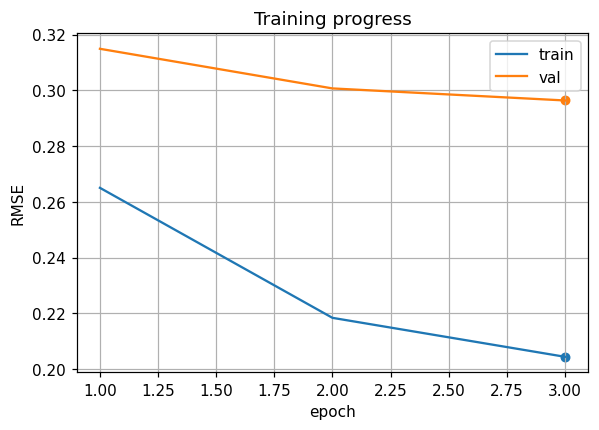

[Epoch 1] GPU alloc = 0.00 GB


Epoch 1: 100%|██████████| 62/62 [00:45<00:00,  1.37bundle/s, lr=0.001, train_rmse=0.265]


Epoch 001 • train=0.2650 • val=0.3149 • lr=1.00e-03
[Epoch 2] GPU alloc = 0.11 GB


Epoch 2: 100%|██████████| 62/62 [00:45<00:00,  1.38bundle/s, lr=0.000999, train_rmse=0.218]


Epoch 002 • train=0.2184 • val=0.3007 • lr=9.99e-04
[Epoch 3] GPU alloc = 0.11 GB


Epoch 3: 100%|██████████| 62/62 [00:42<00:00,  1.44bundle/s, lr=0.000998, train_rmse=0.204]


Epoch 003 • train=0.2044 • val=0.2964 • lr=9.98e-04
[Epoch 4] GPU alloc = 0.11 GB


Epoch 4:  94%|█████████▎| 58/62 [00:40<00:02,  1.52bundle/s, lr=0.000997, train_rmse=0.204]

In [ ]:

# -----------------------------------------------------------------------------
# Count how many calendar days we see each epoch
# -----------------------------------------------------------------------------
n_train_days = len(train_loader.dataset)  # dataset length = # unique days
print(f"Training sees {n_train_days} calendar days per epoch\n")


# -----------------------------------------------------------------------------
# Compute baseline RMSE on validation (zero forecast)
# -----------------------------------------------------------------------------
baseline_val_rmse = models.naive_rmse(val_loader)
print(f"Baseline (zero‐forecast) RMSE on validation = {baseline_val_rmse:.6f}")


# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse = custom_stateful_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = MAX_EPOCHS,
    early_stop_patience = EARLY_STOP_PATIENCE,
    baseline_val_rmse   = baseline_val_rmse,
    clipnorm            = clipnorm,
    plateau_warmup      = PLAT_EPOCHS_WARMUP,   
    device              = device
)

# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement = 100.0 * (1.0 - best_val_rmse / baseline_val_rmse)
print(f"Improvement over zero‐baseline = {improvement:5.1f}%")
